In [1]:
import os
import re

import matplotlib.pyplot as plt
import nltk
import pickle

from sentiment import sentiment
from style import style
from datautils import datautils

SENTIMENT_DATA_PATH = "sentiment/data_with_sentiment.pickle"

In [2]:
sentiment_analyzer = sentiment.SentimentAnalyzer()
sentiment_analyzer.load_sentiment_data("data/wordlist.txt")
sentiment_analyzer.data.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600.0,NaN,NaN,1728.0
1,happiness,2,8.44,0.9723,1853.0,2458.0,NaN,1230.0
2,love,3,8.42,1.1082,25.0,317.0,328.0,23.0
3,happy,4,8.30,0.9949,65.0,1372.0,1313.0,375.0
4,laughed,5,8.26,1.1572,3334.0,3542.0,NaN,2332.0


In [3]:
loader = datautils.Loader()
loader.load("data/characters/")
data = loader.to_dataframe()
loader.drop()

data.head()

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died
0,%22Blue%22_Imcrix,"""Blue"" Imcrix","""Blue"" Imcrix was an infamous male Taloron cri...","[Star_Wars_Legends, Taloron, Gender/Legends, C...",Taloron,Male,NaN,NaN,NaN
1,%22Fugitive%22_Fod,"""Fugitive"" Fod","""Fugitive"" Fod was a male Yuzzum from Endor wh...","[Star_Wars_Legends, Endor/Legends, Yuzzum/Lege...",Yuzzum,Male,NaN,Endor,NaN
2,%22Shady%22_Pers,"""Shady"" Pers","""Shady"" Pers was a male Human smuggler living ...","[Star_Wars_Legends, Kashyyyk/Legends, Human/Le...",Human,Male,[Myyydril],Kashyyyk,NaN
3,%27Ndranth_Poussan,'Ndranth Poussan,'Ndranth Poussan was a Human male starfighter ...,"[Star_Wars_Legends, Wookieepedia:Good_articles...",Human,Male,"[Agamar Resistance, Alliance to Restore the Re...",Agamar,"[1 BBY, near Brigia]"
4,0761,0761,0761 was a stormtrooper who was stationed on C...,"[Star_Wars_Legends, 5_ABY/Legends, Ciutric_IV,...",Human,Male,"[Galactic EmpireStormtrooper Corps, Stormtroop...",NaN,"[5 ABY, Ciutric IV]"


In [4]:
if not os.path.exists(SENTIMENT_DATA_PATH):
    sentiments = []

    for i, row in data.iterrows():
        tokens = nltk.word_tokenize(row.Content)
        tokens = sentiment_analyzer.normalize_text(tokens)
        sentiments.append(sentiment_analyzer.calc_sentiment(tokens))

    data["Sentiment"] = sentiments

    with open(SENTIMENT_DATA_PATH, "wb") as wbfile:
        pickle.dump(data, wbfile)
else:
    with open(SENTIMENT_DATA_PATH, "rb") as rbfile:
        data = pickle.load(rbfile)

data.head()

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died,Sentiment
0,%22Blue%22_Imcrix,"""Blue"" Imcrix","""Blue"" Imcrix was an infamous male Taloron cri...","[Star_Wars_Legends, Taloron, Gender/Legends, C...",Taloron,Male,NaN,NaN,NaN,5.336914
1,%22Fugitive%22_Fod,"""Fugitive"" Fod","""Fugitive"" Fod was a male Yuzzum from Endor wh...","[Star_Wars_Legends, Endor/Legends, Yuzzum/Lege...",Yuzzum,Male,NaN,Endor,NaN,5.826154
2,%22Shady%22_Pers,"""Shady"" Pers","""Shady"" Pers was a male Human smuggler living ...","[Star_Wars_Legends, Kashyyyk/Legends, Human/Le...",Human,Male,[Myyydril],Kashyyyk,NaN,5.538900
3,%27Ndranth_Poussan,'Ndranth Poussan,'Ndranth Poussan was a Human male starfighter ...,"[Star_Wars_Legends, Wookieepedia:Good_articles...",Human,Male,"[Agamar Resistance, Alliance to Restore the Re...",Agamar,"[1 BBY, near Brigia]",5.461783
4,0761,0761,0761 was a stormtrooper who was stationed on C...,"[Star_Wars_Legends, 5_ABY/Legends, Ciutric_IV,...",Human,Male,"[Galactic EmpireStormtrooper Corps, Stormtroop...",NaN,"[5 ABY, Ciutric IV]",5.074118


In [5]:
# remove records without sentiment
data = data[data.Sentiment > 0]
mean_sentiment = data.Sentiment.mean()
percentile10 = data.Sentiment.quantile(0.1)
percentile90 = data.Sentiment.quantile(0.9)

print(f"Average sentiment of all characters:\t\t {mean_sentiment:.2f}")
print(f"10th percentile of sentiment of all characters:\t {percentile10:.2f}")
print(f"90th percentile of sentiment of all characters:\t {percentile90:.2f}")

Average sentiment of all characters:		 5.42
10th percentile of sentiment of all characters:	 5.04
90th percentile of sentiment of all characters:	 5.80


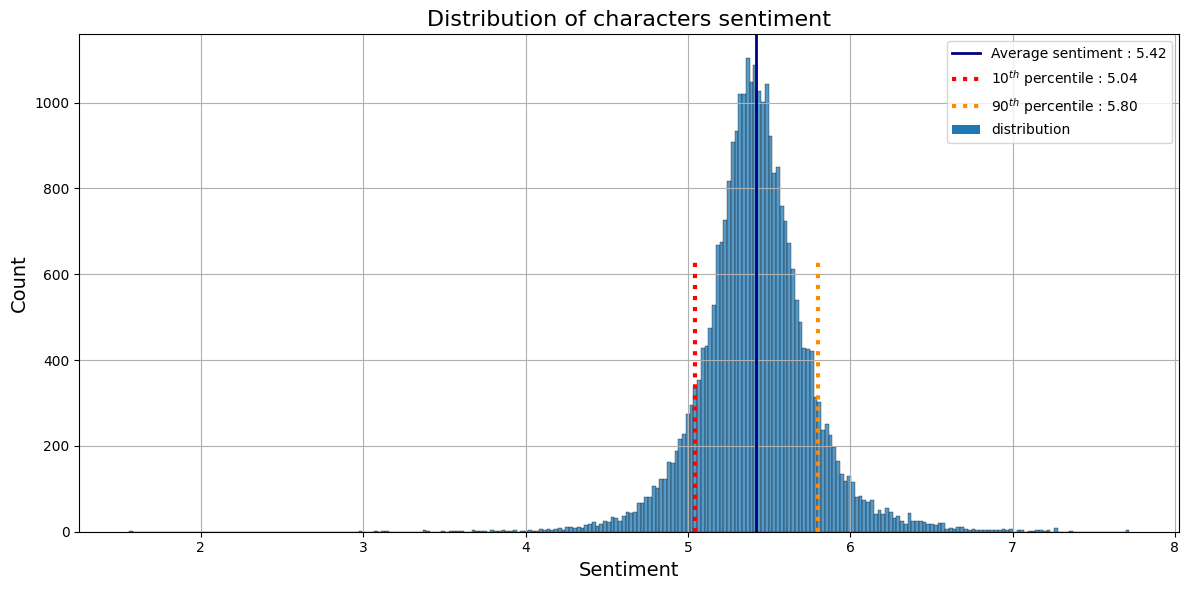

In [6]:
fig, ax = plt.subplots(1, 1, figsize=style.DEFAULT_FIGSIZE)

datautils.plot_distribution(
    data.Sentiment, fig=fig, ax=ax,
    title="Distribution of characters sentiment",
    xlabel="Sentiment",
    ylabel="Count",
)
plt.show()

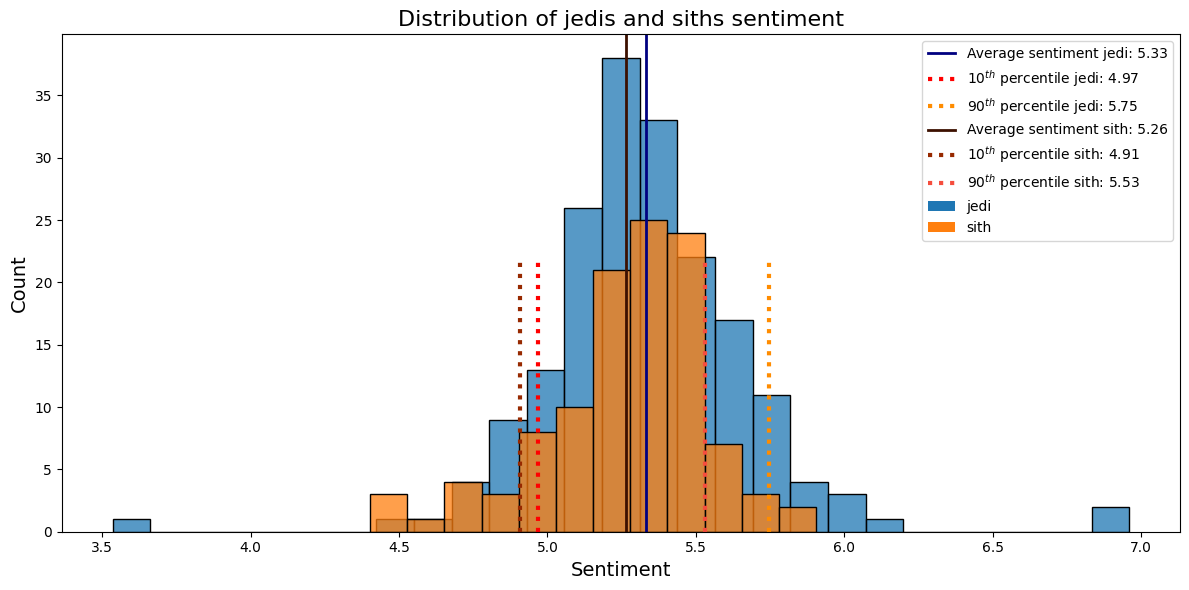

In [7]:
siths = []
jedis = []

for _, row in data[~data["Affiliation(s)"].isna()].iterrows():
    for affiliation in row["Affiliation(s)"]:
        if re.search("sith", row.Name.lower()):
            siths.append(row.Name)
        if re.search("jedi", row.Name.lower()):
            jedis.append(row.Name)

data_sith = data[data.Name.isin(siths)]
data_jedi = data[data.Name.isin(jedis)]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

fig, ax = datautils.plot_distribution(
    data_jedi.Sentiment, fig=fig, ax=ax,
    xlabel="Sentiment",
    ylabel="Count",
    tag="jedi",
)
fig, ax = datautils.plot_distribution(
    data_sith.Sentiment, fig=fig, ax=ax,
    title="Distribution of jedis and siths sentiment",
    xlabel="Sentiment",
    ylabel="Count",
    tag="sith",
    mean_color="#3C1000",
    percentile10_color="#972900",
    percentile90_color="#f54d3d",
)
plt.show()

## Jedi outliers analysis

Low sentiments

In [16]:
jedi_sentiments = data_jedi.sort_values(by="Sentiment")

print(jedi_sentiments.iloc[0].Name)
print()
print(jedi_sentiments.iloc[0].Content)
print()

# find words that are present in wordlist data set
tokens = nltk.word_tokenize(jedi_sentiments.iloc[0].Content)
tokens = sentiment_analyzer.normalize_text(tokens)
print(sentiment_analyzer.in_wordlist(tokens))

Unidentified_Human_male_Jedi_(Jabiim)

This Human Jedi fought in the Battle of Jabiim during the Clone Wars.

{'human': 6.26, 'fought': 3.1, 'battle': 2.98, 'war': 1.8}


High sentiments

In [30]:
print(jedi_sentiments.iloc[-2:].DisplayName.values)
print()
print(jedi_sentiments.iloc[-2:].Content.values)
print()

for _, row in jedi_sentiments.iloc[-2:].iterrows():
    tokens = nltk.word_tokenize(row.Content)
    tokens = sentiment_analyzer.normalize_text(tokens)
    print(f"{row.DisplayName}: {sentiment_analyzer.in_wordlist(tokens)}")

['Unidentified blue-skinned Jedi  (Mace Windu)'
 'Unidentified Quarren Jedi student']

['A Nautolan Jedi discovered Mace Windu as an infant.'
 'An unidentified Quarren Jedi student was a trainee at the Jedi Praxeum on Yavin 4. He was present at the Jedi wedding of Luke Skywalker and Mara Jade.']

Unidentified blue-skinned Jedi  (Mace Windu): {'discovered': 7.0, 'infant': 6.9}
Unidentified Quarren Jedi student: {'student': 6.58, 'present': 6.96, 'wedding': 7.34}


## Anakin case study

In [9]:
anakin = data[data.Name == "Anakin_Skywalker"]
anakin_page_content = anakin.Content.values[0]

anakin_begin = re.search(r"Believed to have been conceived", anakin_page_content)
anakin_end = re.search(r"The Bad Batch", anakin_page_content)
anakin_content = anakin_page_content[anakin_begin.span()[0]:anakin_end.span()[0]]

darth_vader_begin = re.search(r"At some point before the Battle of Coruscant", anakin_page_content)
darth_vader_end = re.search(r"though unsung to everyone except in the eyes of Luke", anakin_page_content)
darth_vader_content = anakin_page_content[darth_vader_begin.span()[0]:darth_vader_end.span()[0]]

In [10]:
tokens = nltk.word_tokenize(anakin_content)
tokens = sentiment_analyzer.normalize_text(tokens)
anakin_sentiment = sentiment_analyzer.calc_sentiment(tokens)
print(f"Anakin sentiment: {anakin_sentiment:.4f}")

Anakin sentiment: 5.3154


In [11]:
tokens = nltk.word_tokenize(darth_vader_content)
tokens = sentiment_analyzer.normalize_text(tokens)
darth_vader_sentiment = sentiment_analyzer.calc_sentiment(tokens)
print(f"Darth sentiment: {darth_vader_sentiment:.4f}")

Darth sentiment: 5.2568


### Throughout his life

In [13]:
paragraphs = []
paragraphs.append({"begin": r"Believed to have been conceived", "end": r"more important for the medical center to receive it"})
paragraphs.append({"begin": r"One day, at the age of 9,", "end": r"with the death of Jinn, slain by Darth Maul"})
paragraphs.append({"begin": r"However, during the Master's funeral", "end": r"see Amidala for a decade"})
paragraphs.append({"begin": r"As he grew, Skywalker's exceptional skills made", "end": r"Skywalker worked on a RazBohan high-encryption comlink"})
paragraphs.append({"begin": r"Ten years after the Battle of Naboo", "end": r"Skywalker received a cybernetic replacement for his lost arm"})
paragraphs.append({"begin": r"Following the engagement on Geonosis", "end": r"fired gas at its mouth on Palpatine's orders"})
paragraphs.append({"begin": r"Even as the Clone Wars continued with", "end": r" back to the sunrise before he passed away"})
paragraphs.append({"begin": r"When the Jedi Council received a 2,000-year-old", "end": r"Yoda but managed to progress as Yoda taught her some skills"})
paragraphs.append({"begin": r"During the defense of Cato Neimoidia", "end": r"The Bad Batch"})
paragraphs.append({"begin": r"At some point before the Battle of Coruscant", "end": r"man he had become, but knew it was too late to turn back"})
paragraphs.append({"begin": r"Soon thereafter, Vader saw Amidala's star skiff", "end": r"Vader ordered to imprison and torture the people of Mon Cala"})
paragraphs.append({"begin": r"Over the next two decades of the Empire's reign", "end": r"Imperialis, under the watch of two Royal Guards"})
paragraphs.append({"begin": r"Vader at last had a chance for his long-awaited rematch with Kenobi", "end": r"Organa back to her cell to await her execution"})
paragraphs.append({"begin": r"After the scout ships sent to Dantooine found", "end": r"defeat and assured him that the Rebels could never win"})
paragraphs.append({"begin": r"By the time three years had passed after the Battle of Yavin", "end": r"Force to pull him from space, rendering him unconscious and taking him prisoner"})
paragraphs.append({"begin": r"Vader returned to the Executor", "end": r"use in their campaign against the Sith"})
paragraphs.append({"begin": r"Qi'ra's operations against the Sith", "end": r"though unsung to everyone except in the eyes of Luke"})

sentiments = []
for paragraph in paragraphs:
    begin = re.search(paragraph["begin"], anakin_page_content)
    end = re.search(paragraph["end"], anakin_page_content)
    content = anakin_page_content[begin.span()[0]:end.span()[0]]
    tokens = nltk.word_tokenize(content)
    tokens = sentiment_analyzer.normalize_text(tokens)
    sentiments.append(sentiment_analyzer.calc_sentiment(tokens))

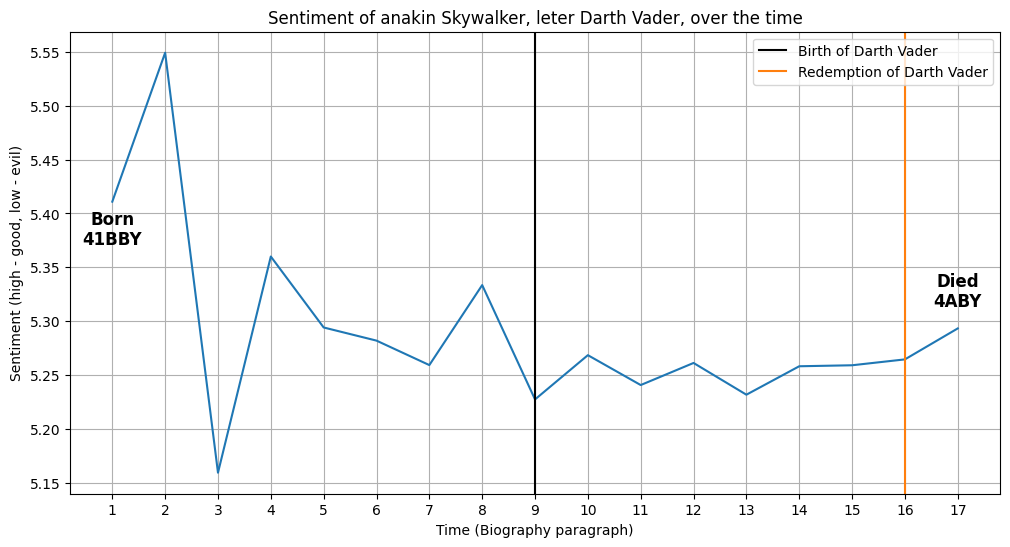

In [14]:
# In step 3 paragraph is short, therefore the bias
# In step 16 Darth Vader redeemed himself, Anakin Sywalker returns

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, 18), sentiments)
ax.set_xticks(range(1, 18))
ax.set_title("Sentiment of anakin Skywalker, leter Darth Vader, over the time")
ax.set_xlabel("Time (Biography paragraph)")
ax.set_ylabel("Sentiment (high - good, low - evil)")
ax.axvline(9, label="Birth of Darth Vader", color="black")
ax.axvline(16, label="Redemption of Darth Vader", color="C1")
ax.annotate("Born\n41BBY", (1, sentiments[0]), ha="center", xytext=(1, sentiments[0]-0.04), weight="bold", size=12)
ax.annotate("Died\n4ABY", (17, sentiments[-1]), ha="center", xytext=(17, sentiments[-1]+0.02), weight="bold", size=12)
ax.grid()

ax.legend()
plt.show()